## Load Environment Variables

In [1]:
from pathlib import Path
from dotenv import load_dotenv

dotenv_path = Path("../help-desk-agent-flask-app/.env").resolve()
_ = load_dotenv(dotenv_path=dotenv_path)

### Load Vector Store
help-desk-agent-flask-app/retriever.py

In [2]:
from langchain_chroma import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from pathlib import Path

_chroma_db_path = Path("../../datasets/help-desk-tickets/chroma_db").resolve()

def load_helpdesk_ticket_vector_store():
    """
    Load a vector store for EHR support tickets using Chroma.
    Raises an error if the directory does not exist.
    """
    if not _chroma_db_path.exists():
        raise FileNotFoundError(f"Chroma DB directory not found: {_chroma_db_path}")

    vector_store = Chroma(
        collection_name="helpdesk_tickets",
        embedding_function=GoogleGenerativeAIEmbeddings(model="models/embedding-001"),
        persist_directory=_chroma_db_path
    )
    return vector_store

### Create RAG Tool
help-desk-agent-flask-app/rag_tool.py

In [3]:
from langchain_core.documents import Document
from typing import List
from langchain_core.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools import convert_runnable_to_tool
from pydantic import BaseModel, Field

_vector_store = load_helpdesk_ticket_vector_store()

class RAGToolArgsSchema(BaseModel):
    question: str = Field(
        description=(
            "A natural language question about electronic health record (EHR) system "
            "tickets or issues, such as 'What is causing pharmacy work stoppages?'"
        )
    )

def get_top_k_documents(query: str) -> List[Document]:
    """Retrieve the top-k documents based on the hyde query."""
    top_k_documents = _vector_store.similarity_search(query, k=3)
    return top_k_documents

def format_documents(documents: List[Document]) -> str:
    """
    Format the retrieved documents into a json string for output
    that includes the TicketID and content.
    """
    docs = []

    for doc in documents:
        ticket_id = doc.metadata.get("TicketID", "UNKNOWN_ID")
        content = doc.page_content
        docs.append(f"TicketID: [{ticket_id}]\n{content}")
    return '\n\n'.join(docs)

def get_rag_tool():
    """
    Create a RAG tool that uses the GoogleGenerativeAI model to generate responses
    """
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=0.7)

    hyde_template = (
    "Based on the question: {question} "
    "Write a passage that could contain the answer to the question: " 
    )
    hyde_prompt = PromptTemplate(
        input_variables=["question"],
        template=hyde_template
    )

    get_top_k_documents_rl = RunnableLambda(get_top_k_documents)
    format_documents_rl = RunnableLambda(format_documents)

    hyde_chain = hyde_prompt | llm | StrOutputParser()
    retreival_chain = get_top_k_documents_rl | format_documents_rl | StrOutputParser()
    rag_chain = hyde_chain | retreival_chain

    rag_tool = convert_runnable_to_tool(
        runnable=rag_chain,
        name="ehr_ticket_rag_retriever",
        description=(
            "Useful for answering questions about EHR system issues using information extracted from support tickets. "
            "Given a question, it generates a hypothesis passage, retrieves relevant tickets, and formats their contents."
        ),
        args_schema=RAGToolArgsSchema
    )
    return rag_tool

#### Test rag_tool

In [4]:
from langchain_core.tools import BaseTool
rag_tool = get_rag_tool()
assert isinstance(rag_tool, BaseTool)
print(f"Tool name: {rag_tool.name}")
print(f"Tool description: {rag_tool.description}")
print(f"Tool schema: {rag_tool.args_schema.model_json_schema()}")

Tool name: ehr_ticket_rag_retriever
Tool description: Useful for answering questions about EHR system issues using information extracted from support tickets. Given a question, it generates a hypothesis passage, retrieves relevant tickets, and formats their contents.
Tool schema: {'properties': {'question': {'description': "A natural language question about electronic health record (EHR) system tickets or issues, such as 'What is causing pharmacy work stoppages?'", 'title': 'Question', 'type': 'string'}}, 'required': ['question'], 'title': 'RAGToolArgsSchema', 'type': 'object'}


In [5]:

question = "Can you summarize what is causing some of the pharmacy work stoppage issues?"

documents = rag_tool.invoke({"question": question})
print(documents)

TicketID: [c27b6138]
UserID: Uf61d0731
UserRole: Nurse
Facility: Boston VA
EHRModule: Pharmacy
Category: Performance Issue
Priority: Medium
Status: Open
ResolutionSummary: 
Body: As a Nurse, it’s hard to work when the Pharmacy screen stalls every few clicks. Is there backend maintenance happening?

TicketID: [0dd06ea2]
UserID: Ua3f6e391
UserRole: Nurse
Facility: Phoenix VA
EHRModule: Pharmacy
Category: Performance Issue
Priority: Medium
Status: Closed
ResolutionSummary: Resolved per SOP.
Body: As a Nurse, it’s hard to work when the Pharmacy screen stalls every few clicks. Is there backend maintenance happening?

TicketID: [48cf2892]
UserID: Uc1b5e9b7
UserRole: Nurse
Facility: Denver VA
EHRModule: Pharmacy
Category: Performance Issue
Priority: Low
Status: In Progress
ResolutionSummary: 
Body: As a Nurse, it’s hard to work when the Pharmacy screen stalls every few clicks. Is there backend maintenance happening?


### Ticket Citation Tool

In [6]:
from langchain_core.tools import tool
from pydantic import BaseModel, Field

class TicketCitationToolArgsSchema(BaseModel):
    ticket_id: str = Field(
        description=(
            "The TicketID for the ticket you would like to cite."
        )
    )

@tool(args_schema=TicketCitationToolArgsSchema)
def ticket_citation_tool(ticket_id: str) -> str:
    """
    Tool to format a url reference to a ticket.
    """
    return f'<a href="https://index/ticket_view?ticket-id={ticket_id}">[{ticket_id}]</a>'

#### Ticket Citation Tool Test

In [7]:
from langchain_core.tools import BaseTool

assert isinstance(ticket_citation_tool, BaseTool)
print(f"Tool name: {ticket_citation_tool.name}")
print(f"Tool description: {ticket_citation_tool.description}")
print(f"Tool schema: {ticket_citation_tool.args_schema.model_json_schema()}")

Tool name: ticket_citation_tool
Tool description: Tool to format a url reference to a ticket.
Tool schema: {'properties': {'ticket_id': {'description': 'The TicketID for the ticket you would like to cite.', 'title': 'Ticket Id', 'type': 'string'}}, 'required': ['ticket_id'], 'title': 'TicketCitationToolArgsSchema', 'type': 'object'}


In [8]:
ticket_citation_tool.invoke({"ticket_id": "12345"})

'<a href="https://index/ticket_view?ticket-id=12345">[12345]</a>'

### ReACT Agent
help-desk-agent-flask-app/agent.py

In [ ]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI

def create_agent_with_memory():
    """
    Create a ReACT agent that uses the RAG tool for answering questions
    about EHR support tickets.
    """
    # Define the system prompt for the agent
    system_prompt = (
    "You are a helpful assistant for the Department of Veterans Affairs (VA) employees. "
    "Your job is to help answer VA employees with questions about issues related to the "
    "electronic health record modernization (EHRM) enterprise rollout. Always use the ticket "
    "citation tool to cite specific tickets that you used in your answer. Only use ticket information "
    "gathered from tools to answer questions. If you do not have enough information, "
    "let the user know that you need more details or to clarify the question."
    )
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=1.0)
    rag_tool = get_rag_tool()
    tools = [rag_tool, ticket_citation_tool]
    memory = MemorySaver()
    agent = create_react_agent(
        model=llm, 
        tools=tools, 
        prompt=system_prompt,
        checkpointer=memory,
    )
    return agent

#### Test Agent

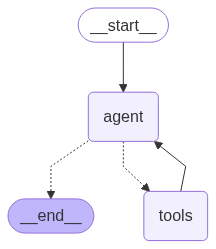

In [ ]:
from IPython.display import Image, display

_react_agent = create_agent_with_memory()
display(Image(_react_agent.get_graph().draw_mermaid_png()))

In [11]:
config = {"configurable": {"thread_id": "tim-session-1"}}

input_message = (
    "Can you help me understand the pharmacy work stoppage issues?"
)

for event in _react_agent.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Can you help me understand the pharmacy work stoppage issues?
================================== Ai Message ==================================
Tool Calls:
  ehr_ticket_rag_retriever (8287421f-3331-470c-b673-bf1086ba4ba8)
 Call ID: 8287421f-3331-470c-b673-bf1086ba4ba8
  Args:
    question: What is causing pharmacy work stoppages?
================================= Tool Message =================================
Name: ehr_ticket_rag_retriever

TicketID: [c27b6138]
UserID: Uf61d0731
UserRole: Nurse
Facility: Boston VA
EHRModule: Pharmacy
Category: Performance Issue
Priority: Medium
Status: Open
ResolutionSummary: 
Body: As a Nurse, it’s hard to work when the Pharmacy screen stalls every few clicks. Is there backend maintenance happening?

TicketID: [48cf2892]
UserID: Uc1b5e9b7
UserRole: Nurse
Facility: Denver VA
EHRModule: Pharmacy
Category: Performance Issue
Priority: Low
Status: In Progress
ResolutionSummary

### Environment & Dependencies

In [12]:
%load_ext watermark
%watermark -a "Tim Strebel" -d -u -v --iversions

Author: Tim Strebel

Last updated: 2025-08-04

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.1.0

langchain_chroma      : 0.2.5
pydantic              : 2.11.7
IPython               : 9.1.0
langchain_core        : 0.3.72
langgraph             : 0.6.2
langchain_google_genai: 2.0.10

